# Initialization
Note that, as in HW-2, the Titanic dataset is locally stored in the folder structure described in the repository Readme.

## Environmental setup

In [1]:
# environmental setup
import os;  import sys;  import numpy as np;  import pandas as pd;  import sklearn

# allow inline display of matplotlib graphs
import matplotlib as mpl;   import matplotlib.pyplot as plt
%matplotlib inline

# suppress errors, as seen in Lecture 8; see SciPy issue #5998
import warnings;   warnings.filterwarnings(action="ignore", message="^internal gelsd")

# unify RNG across runs
seedNum=0;  np.random.seed(seedNum)

print('Environmental setup complete!')

Environmental setup complete!


## Define custom functions
The functions, themselves, are annotated here. The context and significance of these, however, will be explained in the areas where they are actually called.

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

def sep_ports(df_in):
    hotEnc=OneHotEncoder(sparse=False)
    df_embk=df_in[["Embarked"]]
    if len(df_in["Embarked"].unique())>3:     # if input has invalid boarding locations...
        df_embk=df_embk.fillna(value="X")     # replace NaNs with its own category
        df_ohot=hotEnc.fit_transform(df_embk) # one-hot encode for ports C, Q, S, and X (dummy)
        df_ohot=df_ohot.astype(np.float64)    # convert X into flat probability distributions
        for n in range(df_ohot.shape[0]):
            if np.array_equal(df_ohot[n,-1], 1):
                df_ohot[n,:]=[1/3, 1/3, 1/3, 1]
        df_ohot=df_ohot[:,0:-1]               # delete category X from the encoded output
    else:
        df_ohot=hotEnc.fit_transform(df_embk).astype(np.float64)
    df_out=pd.DataFrame(df_ohot,
                        columns=["Cherbourg","Queenstown","Southampton"]) # convert to dataframe
    return df_out

def med_ages(df_in):
    return df_in["Age"].fillna( round(df_in["Age"].mean(),4) )

def bin_sexes(df_in):
    df_gndr=df_in[["Sex"]]
    df_gndr_bin=pd.DataFrame(columns=['isFemale'], index=np.arange(df_in.shape[0])) # initialize dataframe
    for n in range(df_in.shape[0]):
        df_gndr_now=df_gndr.loc[n].values.astype(str)# get gender of current passenger
        # compare string to 'female'
        if df_gndr_now=="female":
            df_gndr_bin.loc[n]=True
        else:
            df_gndr_bin.loc[n]=False
    df_out=df_gndr_bin.astype(np.int64)             # convert to integer to allow for plotting, later
    return df_out

def med_fare(df_in):
    imputeMed=SimpleImputer(strategy="median")
    df_Nage=imputeMed.fit_transform(df_in[["Fare"]])# apply simple imputer to "fare" category
    df_out=pd.DataFrame(df_Nage, columns=["Fare"])  # convert to dataframe
    return df_out

def parse_cabins(df_in):
    subst=51
    df_cabn=df_in[["Cabin"]].fillna(value="D51")# force NaN cabin entries to force assignment on D51
    df_cabn["Deck"]=df_cabn["Cabin"].str[0]     # separate cabin numbers into decks and rooms
    df_cabn["Room"]=df_cabn["Cabin"].str[1:]
    roomNum=df_cabn["Room"];   deckNum=df_cabn["Deck"] # isolate columns to optimize legibility/memory
    roomNum=roomNum.str.split(pat=None,n=2,expand=True)[[0]] # only use the first listed room number
    roomNum=roomNum.fillna(value=subst)         # replace w/ placeholder (see stackoverflow.com/questions/55584352)
    for n in range(df_in.shape[0]):             # if necessary, correct redundant deck names (should NOT be strings)
        if isinstance(roomNum[0][n],str):       # if a room "number" erroneously ended up being a string...
            deckHeader=list(roomNum[0][n])[0]   # get 1st character in current row; should be an integer
            if deckHeader.isalpha():            # is deckHeader truly erroneous, or just somehow a string?
                deckNum.loc[n]=deckHeader
                roomNum.loc[n]=int(roomNum[0][n].split(deckHeader,2)[-1])
            else:
                roomNum.loc[n]=int(roomNum[0][n])
    # even=port, odd=starboard
    #     FRONT           REAR                     FRONT           REAR
    # A:  ?-??            ??+                  B:  1-??            ??+
    # C:  1-54,56,58,60   55,57,59,61+         D:  1-50            51+
    # E:  ?                                    F:  ?
    # G:  ?                                    T:      doesn't matter
    ordEnc=OrdinalEncoder()
    deckNum=ordEnc.fit_transform(pd.DataFrame(deckNum)).astype(np.int64) # apply ordinal encoding onto deck names
    df_cabn["RoomNum"]=roomNum;   df_cabn["DeckNum"]=deckNum # return transformation as new column
    df_out=df_cabn[["DeckNum","RoomNum"]]                    # only keep cabin decks and room numbers
    return df_out

def plot_roc(fpr, tpr):
    plt.plot([0, 1],[0, 1], "k:", linewidth=2)
    plt.plot(fpr, tpr, "r-", linewidth=2)
    plt.xlabel("Specificity (FPR)", fontsize=16);  plt.ylabel("Sensitivity (TPR)", fontsize=16)
    plt.axis([0, 1, 0, 1]);  plt.grid(True)

def plot_pvr(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16);  plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1]);  plt.grid(True)

print('Function definition complete!')

Function definition complete!


## Titanic-specific configuration
The dataset contains the following categories; each category also denotes whether it will be kept as a feature in this assignment.

| Variable Name | Variable Meaning             | # in Train | # in Test | Type    | Keep?      | If needed, convert |
| :---          | :---                         | ---:       | ---:      | :---    | :---       | :---               |
| PassengerId   | ID of psgr. for this contest | 891        | 418       | int64   | Index      | n/a                |
| Survived      | Did this passenger survive?  | 891        | n/a       | int64   | Train Only | n/a                |
| Pclass        | Passenger's boarding class   | 891        | 418       | int64   | Yes        | n/a                |
| Name          | Passenger's full name        | 891        | 418       | object  | No         |                    |
| Sex           | Passenger's biological sex   | 891        | 418       | object  | Yes        | 0 = M, 1 = F       |
| Age           | Passenger's age              | 714        | 332       | float64 | Yes        | Median of Ship     |
| SibSp         | # of sibling/spouse on board | 891        | 418       | int64   | Yes        | n/a                |
| Parch         | # of parents/kids on board   | 891        | 418       | int64   | Yes        | n/a                |
| Ticket        | Ticket ID                    | 891        | 418       | object  | No         |                    |
| Fare          | Fair paid by passenger (GBP) | 891        | 417       | float64 | Yes        | Median of Ship     |
| Cabin         | Passenger's cabin number     | 204        | 91        | int64   | Yes        | Deck, Room         |
| Embarked      | Port where passenger got on  | 889        | 418       | int64   | Yes        | 1-Hot Encode       |

In [3]:
# identify dataframe columns to keep
keepMe=["PassengerId","Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked"]

# read content of training + test datasets
dsmpl=pd.read_csv('../Datasets/Titanic/train.csv')
dtest=pd.read_csv('../Datasets/Titanic/test.csv')

# keep only parts of the dataframe as defined at top of this cell
dsmpl_truth=dsmpl["Survived"];  dsmpl=dsmpl[keepMe];  dtest=dtest[keepMe]

print('Data loading complete!')

Data loading complete!


# Prepare data for analysis
For the purposes of this analysis, the following transformations were made to the dataset.

Note that, for both the training and test datasets, the below categories are assumed to always be defined:

* Class
* Sex
* SibSp
* ParCh

## Embarkment Location
One-hot encoding was applied to convert embarkment locations into probability densities. Passengers with unknown boarding ports were listed so that they are equally likely to have boarded Southampton, Queenstown, or Cherbourg; passengers with known boarding ports were denoted to have had a 100% chance of boarding at that port-of-call.

## Age/Fare
Passengers with unknown ages were imputed to have the median age of all passengers in the inputted dataset. The same was done for passenger fares.

## Sex
Passengers' genders were changed so that females are true (1), while males are false (0).

## Cabin Number
Since cabin numbers on the *Titanic* encode both the deck (A through G) and individual room numbers, each string was split into those components. Room numbers were simply redefined as integers, while decks were converted to ordinals.

If a passenger booked multiple rooms, only use the first room number as a feature. For example, Passgener Index 27 in the training set booked rooms C23, C25, and C27. For this passenger, only the room C23 will be used for the input. Note that, as the deck ID (1st char. in string) is already removed, the preprocessing code only needs to extract the numbers that precede the first space (i.e. what separates C23 from C25).

If the cabin number of a passenger is unknown, they were considered to have resided in the "median" of the ship, which implies Deck D. Since the cabins switch from bow to aft at 50 but there are more rooms on the aft side in Deck D, the "default" value was asserted to be room 51

See https://en.wikipedia.org/wiki/RMS_Titanic#Dimensions_and_layout for more information on the ship's layout.

The layout of the D deck is available at https://www.encyclopedia-titanica.org/titanic-deckplans/d-deck.html

It should be noted that a more informed implementation of this project would take into account the physical location of each cabin. For example, room D51 is towards the aft of the ship, but D50 is closer to the bow; even-numbered cabins, at least in the D deck, were on the port side while odd-numbered cabins were starboard.

However, in the interest of maintaining the integrity of the Kaggle competition, information like these were purposely ignored and NOT converted into additional features.

In [4]:
dsmpl_embk_ohot=sep_ports(dsmpl)    # separate ports
dsmpl_Nage_impu=med_ages(dsmpl)     # impute ages
dsmpl_gndr_bin =bin_sexes(dsmpl)    # binarize ages
dsmpl_fare_impu=med_fare(dsmpl)     # impute fares
dsmpl_cabn_abrv=parse_cabins(dsmpl) # parse cabin information

dsmpl_kept=dsmpl[["Pclass","SibSp","Parch"]] # identify intact portions of training dataset

# combine transformed data into single dataframe
dsmpl_input=pd.concat([
    dsmpl_kept,
    dsmpl_Nage_impu,
    dsmpl_gndr_bin,
    dsmpl_cabn_abrv,
    dsmpl_fare_impu,
    dsmpl_embk_ohot
],axis=1)

print('Transformations complete! See below for transformation result:')
dsmpl_input

Transformations complete! See below for transformation result:


,Pclass,SibSp,Parch,Age,isFemale,DeckNum,RoomNum,Fare,Cherbourg,Queenstown,Southampton
0,3,1,0,22.0000,0,3,51,7.2500,0.0,0.0,1.0
1,1,1,0,38.0000,1,2,85,71.2833,1.0,0.0,0.0
2,3,0,0,26.0000,1,3,51,7.9250,0.0,0.0,1.0
3,1,1,0,35.0000,1,2,123,53.1000,0.0,0.0,1.0
4,3,0,0,35.0000,0,3,51,8.0500,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,27.0000,0,3,51,13.0000,0.0,0.0,1.0
887,1,0,0,19.0000,1,1,42,30.0000,0.0,0.0,1.0
888,3,1,2,29.6991,1,3,51,23.4500,0.0,0.0,1.0
889,1,0,0,26.0000,0,2,148,30.0000,1.0,0.0,0.0


## Display preprocessed data

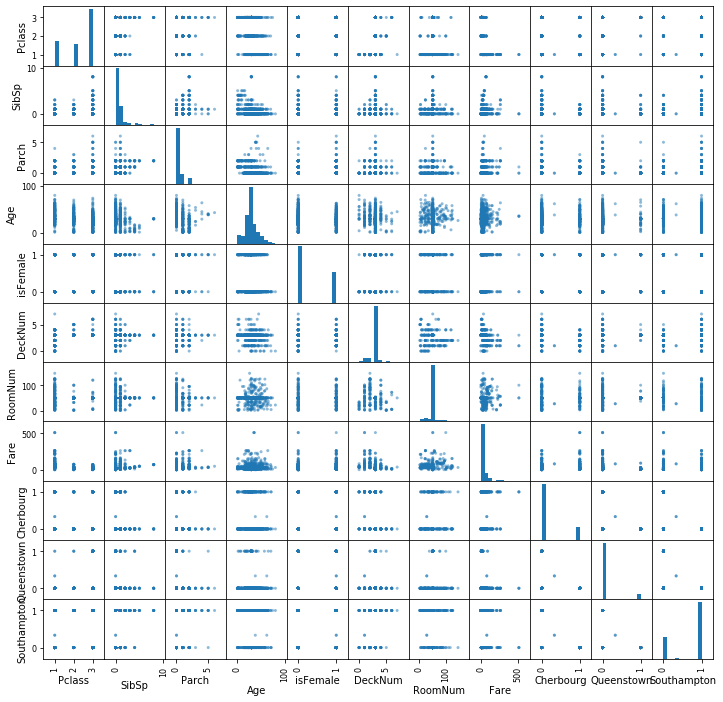

In [5]:
# generate matrix of scatter plots for all variables
from pandas.plotting import scatter_matrix
sctr=scatter_matrix(dsmpl_input, figsize=(12,12), range_padding=0.6)

# Train model
Now that the training dataset has been pruned and transformed into a ML-friendly format, various learning techniques will be employed (and, eventually, the best variant of the best learning type will be identified).

## Create models
First, default or modified-default hyperparameters for various learning models will be defined.

In [6]:
# if valid, number of iterations to train per epoch + tolerance
iterVal=10000
toleVal=1e-4

from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import MultinomialNB

# create all the models
models={
    'stochastic gradient descent':    SGDClassifier(random_state=seedNum,max_iter=iterVal,tol=toleVal),
    #'logistic regression':       LogisticRegression(random_state=seedNum,max_iter=iterVal,tol=toleVal,penalty='elasticnet',solver='saga',l1_ratio=0.5,class_weight='balanced'),
    'perceptron':                        Perceptron(random_state=seedNum,max_iter=iterVal,tol=toleVal,penalty='elasticnet'),
    'decision trees':        DecisionTreeClassifier(random_state=seedNum),
    'random forest':         RandomForestClassifier(random_state=seedNum),
    'bagged trees':               BaggingClassifier(random_state=seedNum),
    'support vector machines':                  SVC(random_state=seedNum,max_iter=iterVal,tol=toleVal,class_weight='balanced',gamma='scale'),
    'linearized SVMs':                    LinearSVC(random_state=seedNum,max_iter=iterVal,tol=toleVal,dual=False),
    'k-nearest neighbors':     KNeighborsClassifier(),
    #'Gauss. proc. clsf.': GaussianProcessClassifier(),
    'naive multinom. Bayesian':       MultinomialNB()
}

# initialize dictionary to store cross-validation scores + guesses
guesses=models.fromkeys(models,0);  scores=guesses

print('Model creation complete!')

Model creation complete!


## Train and characterize models
The above learning methods will be trained and cross-validated; this will allow for easy discrimination of the rough performance of the model in the given environment.

In [7]:
epochs=20 # number of epochs to train
numxVal=10 # number of folds for cross-validation

ML_in=dsmpl_input
truth=dsmpl_truth

import time
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# initialize dataframe to store ML parameters
resultLabel=( ['Algorithm Name','% Accurate','% Std. Dev.',
               'False Death','False Survival',
               'Precision','Recall','F1','AUC',
               'Training Time (s)'] )
results=pd.DataFrame(columns=resultLabel)

for MLname,MLnow in zip(models.keys(), models.values()):
    
    t0=time.time()
    for epoch in range(epochs):
        
        # fit model to data
        MLnow.fit(ML_in, truth)
        
        # determine cross-validation guesses and scores
        guess=cross_val_predict(MLnow, ML_in, truth, cv=numxVal)
        score=cross_val_score(  MLnow, ML_in, truth, cv=numxVal, scoring="accuracy")
        
        # find confusion matrix (precision/recall is shown graphically)
        conf=confusion_matrix(truth,guess)
        
        # identify precision/recall curve and area under ROC curve
        prc=round( precision_score(truth,guess), 2)
        rec=round( recall_score(truth,guess),    2)
        f1s=round( f1_score(truth,guess),        2)
        auc=round( roc_auc_score(truth,guess),   2)
        
    # print time taken to go through all epochs
    tTrain=round(time.time()-t0, 1)
 
    # store results
    pctAcc=round( 100*score.mean(), 1 )
    pctStd=round( 100*score.std(),  1 )
    resultNow=[[MLname, pctAcc, pctStd, conf[1,0], conf[0,1], prc, rec, f1s, auc, tTrain]]
    results=results.append(pd.DataFrame(resultNow,columns=resultLabel),ignore_index=True)
    print("Training complete for",MLname)

print(); print('Training complete! See below for rough performance result:')
results

Training complete for stochastic gradient descent
Training complete for perceptron
Training complete for decision trees


/Users/keita/anaconda3/envs/bmme890/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training complete for random forest
Training complete for bagged trees
Training complete for support vector machines
Training complete for linearized SVMs
Training complete for k-nearest neighbors
Training complete for naive multinom. Bayesian

Training complete! See below for rough performance result:


,Algorithm Name,% Accurate,% Std. Dev.,False Death,False Survival,Precision,Recall,F1,AUC,Training Time (s)
0,stochastic gradient descent,66.9,10.5,125,170,0.56,0.63,0.60,0.66,2.2
1,perceptron,55.8,15.5,124,270,0.45,0.64,0.53,0.57,1.7
2,decision trees,76.1,4.1,106,107,0.69,0.69,0.69,0.75,1.8
3,random forest,80.8,5.4,98,73,0.77,0.71,0.74,0.79,5.7
4,bagged trees,80.4,5.6,103,72,0.77,0.70,0.73,0.78,8.0
5,support vector machines,69.3,6.6,160,114,0.61,0.53,0.57,0.66,9.2
6,linearized SVMs,78.9,2.0,108,80,0.75,0.68,0.71,0.77,2.1
7,k-nearest neighbors,70.5,5.0,158,105,0.64,0.54,0.58,0.67,2.6
8,naive multinom. Bayesian,66.9,5.3,204,91,0.60,0.40,0.48,0.62,1.3


## Optimize training
Select the best model type, then tune its hyperparameters via grid-search cross-validation.

In [8]:
from sklearn.model_selection import GridSearchCV

ML_optim=RandomForestClassifier(random_state=seedNum)
print("The optimal model type has been selected!")

# define parameters to search through
params=[{
    'n_estimators':[5, 10, 15, 20, 25],
    'max_features':[3,4,5,6],
    'max_depth':[None, 3, 4, 5, 10],
    'min_samples_leaf':[1, 2, 5]
}]

# apply grid search parameters to chosen model
searchMe=GridSearchCV(ML_optim,
                      param_grid=params,
                      cv=5,
                      scoring='brier_score_loss',
                      return_train_score=True)

# try out different hyperparameters and identify performance results
searchMe.fit( ML_in, truth )

print("Grid-searching is complete! Run the next cell to find the best hyperparameters.")

The optimal model type has been selected!
Grid-searching is complete! Run the next cell to find the best hyperparameters.


The mean Brier score (mean square difference between predicted and true probability) of the most optimal grid search (using the above parameters) is as follows:

In [9]:
CVresult=searchMe.cv_results_

# find threshold test score
CVthres=round( abs(CVresult["mean_test_score"]).min(),5)

for avgScore,params in zip( CVresult["mean_test_score"], CVresult["params"]):
    avgNow=abs(round(avgScore,5))
    if avgNow == CVthres:
        print('Mean Brier loss:', avgNow)
        print(params)

Mean Brier loss: 0.13076
{'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 25}


# Apply desired model to test dataset
Define an ML model and its hyperparameters...

In [10]:
ML_useMe=RandomForestClassifier(random_state=seedNum,
                                n_estimators=25,
                                max_features=3,
                                max_depth=10,
                                min_samples_leaf=2)

for epoch in range(epochs):
    ML_useMe.fit(ML_in,truth)

...and apply it to the test dataset.

In [11]:
# Apply transformations also used on the training dataset
dtest_embk_ohot=sep_ports(dtest) # separate ports
dtest_Nage_impu=med_ages(dtest)  # impute ages
dtest_gndr_bin =bin_sexes(dtest) # binarize ages
dtest_fare_impu=med_fare(dtest)  # impute fares
dtest_cabn_abrv=parse_cabins(dtest)# parse cabin information

# combine transformed data into single dataframe
dtest_kept=dtest[["Pclass","SibSp","Parch"]]
dtest_input=pd.concat([dtest_kept, dtest_Nage_impu, dtest_gndr_bin,
                       dtest_cabn_abrv, dtest_fare_impu, dtest_embk_ohot],
                      axis=1)

# apply desired ML model to test dataset
dtest_out=ML_useMe.predict(dtest_input);

# concatenate with passenger ID, and convert to dataframe
dtest_out=pd.concat([dtest[["PassengerId"]],
                     pd.DataFrame(dtest_out, columns=["Survived"])],
                   axis=1)

# use passenger ID as dataset index
dtest_out=dtest_out.set_index('PassengerId').Survived

# save result
dtest_out.to_csv('test-output.csv', header=True)